In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
import random
from tqdm import tqdm

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import seaborn as sns

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix

from keras import backend as K
import gc

In [ ]:
!git clone https://github.com/EdoardoGit/ML_Colab.git

Cloning into 'ML_Colab'...
remote: Enumerating objects: 24980, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 24980 (delta 0), reused 6 (delta 0), pack-reused 24974
Receiving objects: 100% (24980/24980), 895.68 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (25003/25003), done.


In [ ]:
CATEGORIE = ("Dogs/","Cats/")
DIR='/content/ML_Colab/CatsDogs/'
IMG_SIZE = 60

In [ ]:
EARLY_STOP_PATIENCE=10
OUTPUT_LOSS_PATH="output_loss_fold"
OUTPUT_VAL_PATH="output_val_fold"
OUTPUT_CONF_PATH="output_conf_fold"
OUTPUT_MEAN_LOSS_PATH="output_mean_loss"
OUTPUT_MEAN_ACC_PATH="output_mean_acc"
OUTPUT_MEAN_CONF_PATH="output_mean_conf"

In [ ]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161, 
               10190, 10237, 10401, 10797, 11186]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377, 
               8456, 8470, 11565, 12272]

In [ ]:
bad_ids=[]
for n in bad_dog_ids:
  bad_ids.append([str(n)+".jpg",0])
for n in bad_cat_ids:
  bad_ids.append([str(n)+".jpg",1])

In [ ]:
#costruisco il dataset con IMG(color),label
def create_training_data():
  training_data = []
  bad_data=[]
  for categories in CATEGORIE:
    path = os.path.join(DIR,categories)
    print(path)
    class_num = CATEGORIE.index(categories)
    for image in tqdm(os.listdir(path)):
      if([image,class_num] in bad_ids):
        try:
          img_array = cv2.imread(os.path.join(path,image))
          #print(image)
          #if img_array is None:
          #  print('Wrong path:', os.path.join(path,image))
          #else:
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

          bad_data.append([new_array,class_num])
        except Exception as e:
          #print("Immagine danneggiata")
          pass
      else:
        try:
          img_array = cv2.imread(os.path.join(path,image))
          #print(img_array.shape)
          #if img_array is None:
          #  print('Wrong path:', os.path.join(path,image))
          #else:
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

          training_data.append([new_array,class_num])
        except Exception as e:
          #print(e)
          pass
  return training_data,bad_data

In [ ]:
data,bad_data=create_training_data()
print(len(data))

/content/ML_Colab/CatsDogs/Dogs/


100%|██████████| 12500/12500 [00:28<00:00, 445.45it/s]


/content/ML_Colab/CatsDogs/Cats/


100%|██████████| 12500/12500 [00:27<00:00, 451.00it/s]

24930


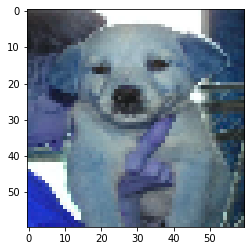

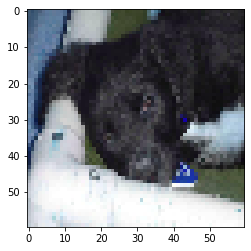

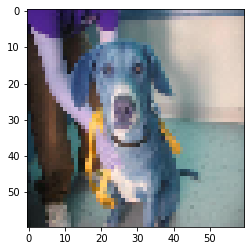

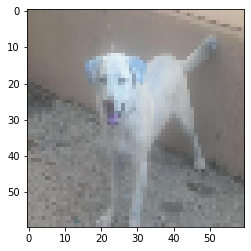

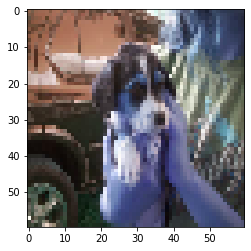

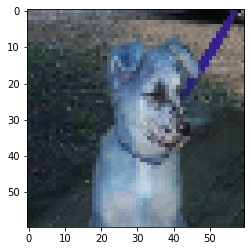

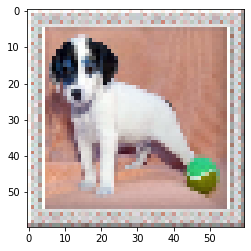

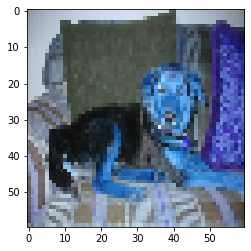

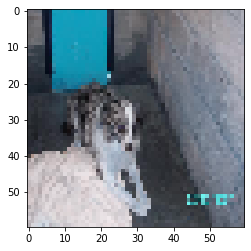

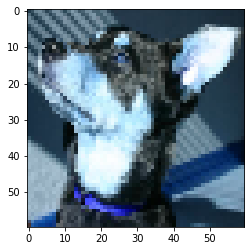

In [ ]:
for sample in data[:10]:
  plt.imshow(sample[0])
  plt.show()

In [ ]:
random.shuffle(data)
print(len(data))

24930


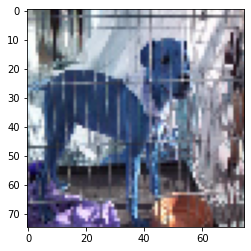

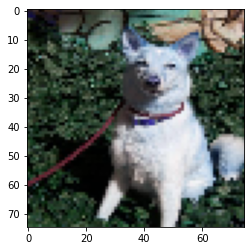

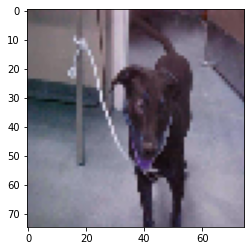

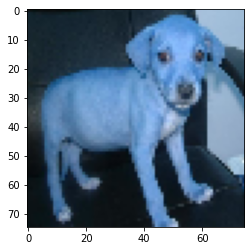

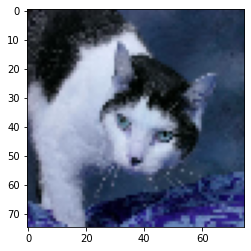

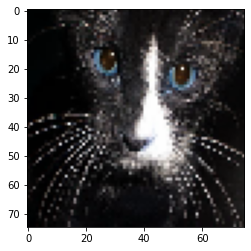

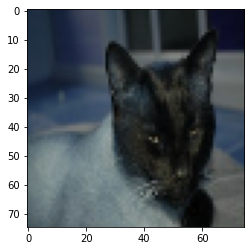

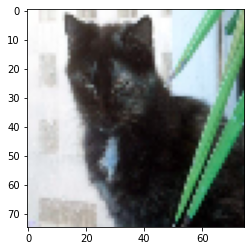

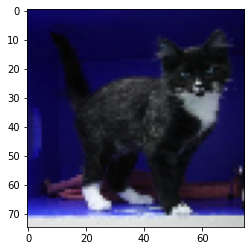

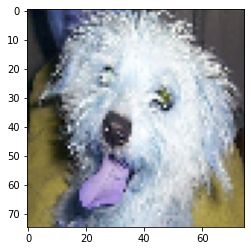

In [ ]:
#check dei primi 10 campioni dopo lo shuffle
#Dogs->0 Cats->1
for sample in data[:10]:
  plt.imshow(sample[0])
  plt.show()

In [ ]:
def data_construct(data):
  input=[]
  output=[]

  for img,label in data:
    input.append(img)
    y=np.zeros(len(CATEGORIE))
    y[label]=1
    output.append(y)
  input=np.array(input).reshape(-1,IMG_SIZE,IMG_SIZE,3)
  return input,output

In [ ]:
X,y = data_construct(data)

In [ ]:
print(X.shape)

(24930, 60, 60, 3)


In [ ]:
X.shape[1:]

(60, 60, 3)

In [ ]:
#converto e normalizzo X
X=np.asarray(X)
y=np.asarray(y)
X = X/ 255

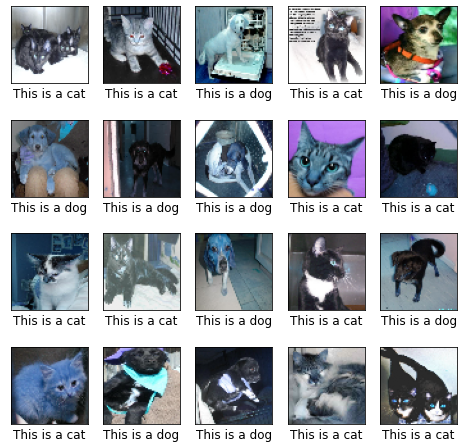

In [ ]:
#check dei primi 20 campioni
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.xlabel(f'This is a {"dog" if y[i][0] == 1 else "cat"}', size=12)
plt.savefig('grid_example')
plt.show()

In [ ]:
#h->train history, path->dove salvare
def save_loss_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  #plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["custom_zero_loss"],label="0-1_loss")
  #plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  plt.plot(H.history["val_custom_zero_loss"],label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train Loss and 0-1 Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->train history, path->dove salvare
def save_val_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  #plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  #plt.plot(H.history["val_custom_zero_loss"],label="val_loss")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix delle fold
def save_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix media
def save_mean_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  cfm=cfm/n_splits
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la loss media
def save_mean_loss_plot(mloss,mozloss,meanvalozloss,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(mloss,label="train_loss")
  plt.plot(mozloss,label="train_0-1_loss")
  plt.plot(meanvalozloss,label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la accuracy media
def save_mean_acc_plot(macc,mvalacc,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(macc,label="train_acc")
  plt.plot(mvalacc,label="val_acc")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
m=tf.keras.metrics.CategoricalAccuracy()

In [ ]:
def custom_zero_loss(y_true, y_pred):
  m.reset_state()
  m.update_state(y_true,y_pred)
  return 1-m.result()

RESNET50

In [ ]:
#definisco l'early stopping per il training
from tensorflow.keras.callbacks import EarlyStopping

stop_early_test=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco la funzione di LR reduction
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

In [ ]:
#definisco l'architettura (ResNet50)
def model_builder():
  resnet_model = Sequential()

  res_model=keras.applications.ResNet50(include_top=False,
                                               input_shape = X.shape[1:],
                                               pooling='avg',
                                               classes=2,
                                               weights='imagenet')
  resnet_model.add(res_model)
  resnet_model.add(Flatten())
  resnet_model.add(Dense(512,activation='relu'))
  resnet_model.add(Dense(2,activation='softmax'))

  resnet_model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return resnet_model

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=50
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early_test,learning_rate_reduction],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
312/312 [==============================] - 45s 95ms/step - loss: 0.3989 - categorical_accuracy: 0.8354 - custom_zero_loss: 0.1645 - val_loss: 0.8269 - val_categorical_accuracy: 0.4948 - val_custom_zero_loss: 0.5053 - lr: 0.0010
Epoch 2/50
312/312 [==============================] - 27s 86ms/step - loss: 0.2302 - categorical_accuracy: 0.9045 - custom_zero_loss: 0.0954 - val_loss: 0.7467 - val_categorical_accuracy: 0.5024 - val_custom_zero_loss: 0.4977 - lr: 0.0010
Epoch 3/50
312/312 [==============================] - 28s 88ms/step - loss: 0.1591 - categorical_accuracy: 0.9365 - custom_zero_loss: 0.0634 - val_loss: 0.3709 - val_categorical_accuracy: 0.8385 - val_custom_zero_loss: 0.1614 - lr: 0.0010
Epoch 4/50
312/312 [==============================] - 28s 90ms/step - loss: 0.1544 - categorical_accuracy: 0.9403 - custom_zero_loss: 0.0598 - val_loss: 0.5718 - val_categorical_accuracy: 0.7876 - val_custo

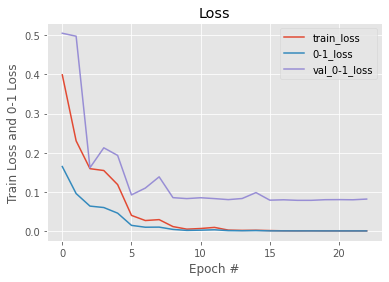

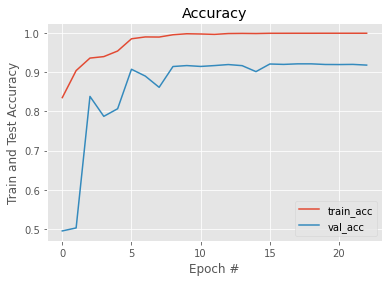

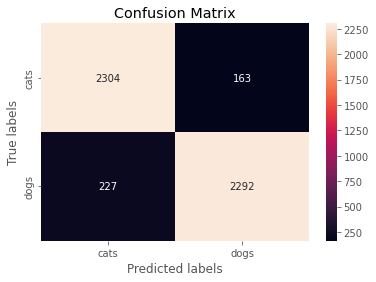

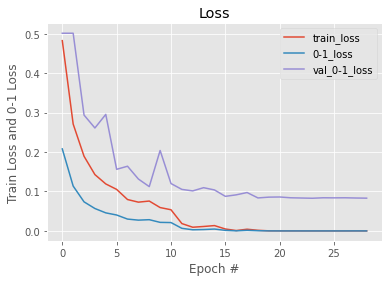

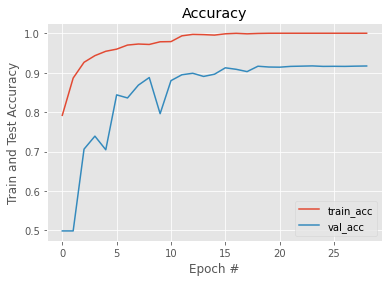

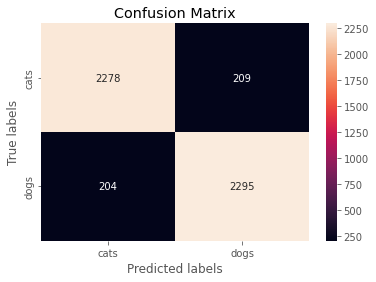

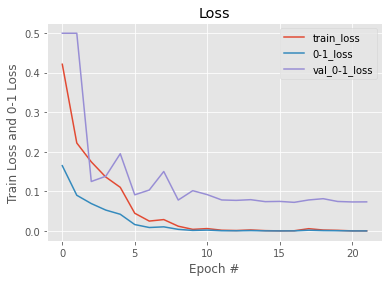

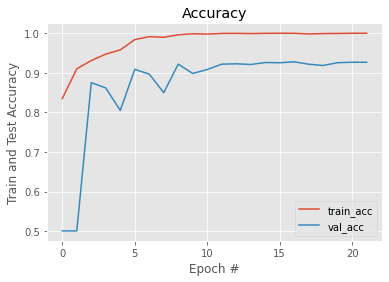

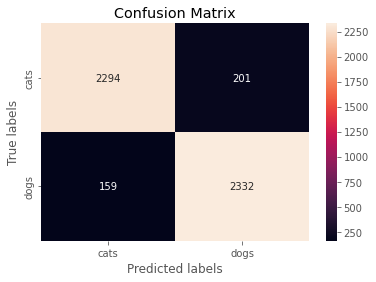

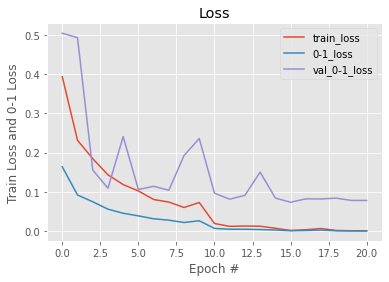

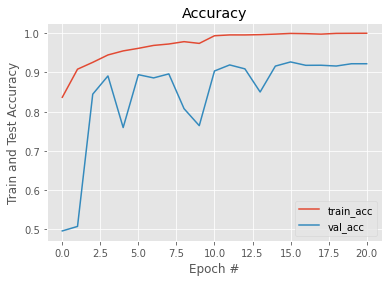

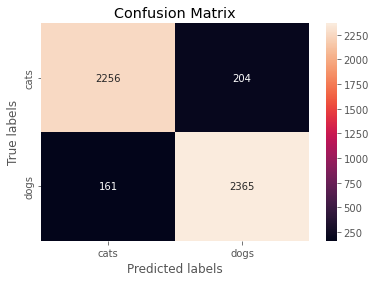

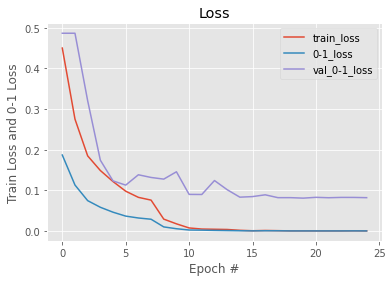

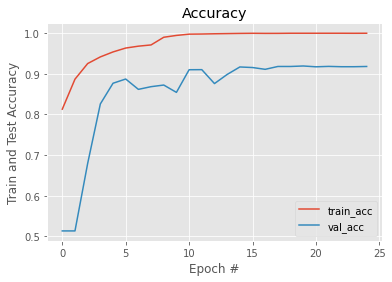

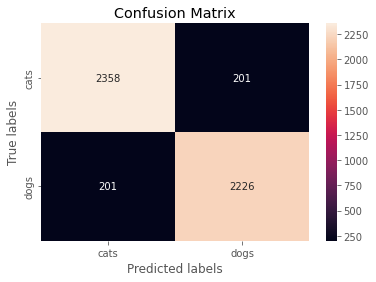

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5361605286598206 - Accuracy: 0.9217810034751892 - Zero-One N Loss: 390 - Zero-One Loss: 0.07821901323706382
------------------------------------------------------------------------
> Fold 2 - Loss: 0.581388533115387 - Accuracy: 0.9171680808067322 - Zero-One N Loss: 413 - Zero-One Loss: 0.08283192940232653
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4802125096321106 - Accuracy: 0.9277978539466858 - Zero-One N Loss: 360 - Zero-One Loss: 0.07220216606498198
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4445512890815735 - Accuracy: 0.9267950057983398 - Zero-One N Loss: 365 - Zero-One Loss: 0.07320497392699554
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5570046901702881 - Accuracy: 0.9193742275238037 - Zero-One N Loss: 402 - Zero-One Loss: 0.0806

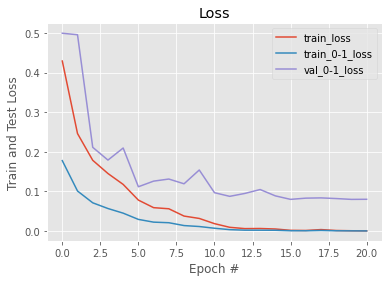

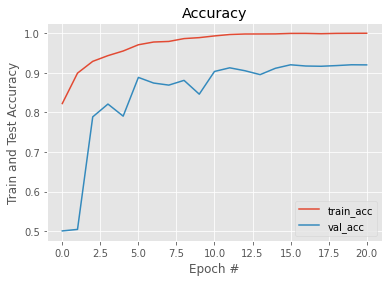

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2298.   195.6]
 [ 190.4 2302. ]]


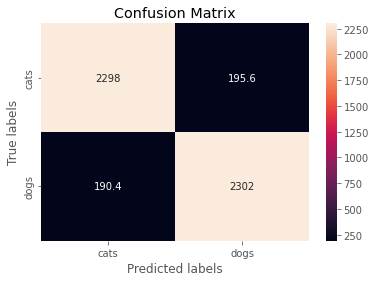

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

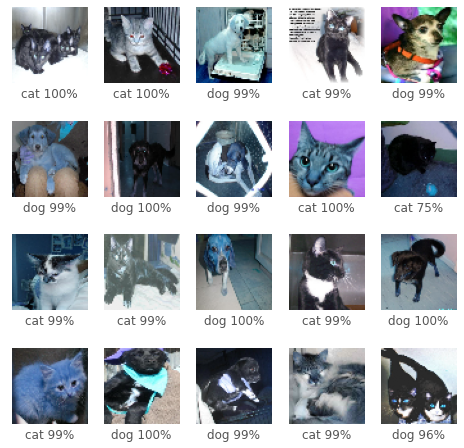

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

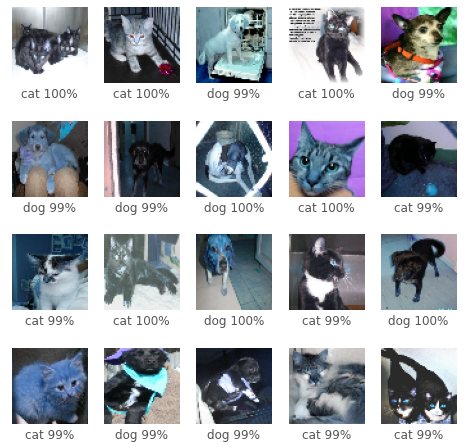

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

In [ ]:
model=model_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 24,584,706
Non-trainable params: 53,120
_________________________________________________________________
